In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString , Polygon

In [3]:
# getting the path of the current jupyter notebook
Path.cwd()

WindowsPath('G:/Omdena/wfpdisrel/#task1-datacollection/#task1-datacollection-climada/notebooks')

In [4]:
# reading in the cyclone data
data_folder = Path.cwd().parent.parent.joinpath('best_tracks')
#print(data_folder)
input_filename = 'epac-atl.csv'
input_file = Path(data_folder).joinpath(input_filename)
print(input_file)

G:\Omdena\wfpdisrel\#task1-datacollection\best_tracks\epac-atl.csv


In [6]:
## TODO: Reference the correct dataset - this one has the longitude error! 
df_input = pd.read_csv(input_file)

In [7]:
cyclone_name = "IVAN"
cyclone_year = 2004

In [9]:
df_input.head()

,Unnamed: 0,id,name,time,year,lat,long,m_w_speed,mcp,rmw,...,NE_50,SE_50,SW_50,NW_50,NE_64,SE_64,SW_64,NW_64,max_50,max_64
0,0,AL0188,ALBERTO,80518,1988,32.0,77.5,20,1015,-99,...,0,0,0,0,0,0,0,0,0.0,0.0
1,1,AL0188,ALBERTO,80600,1988,32.8,76.2,20,1014,-99,...,0,0,0,0,0,0,0,0,0.0,0.0
2,2,AL0188,ALBERTO,80606,1988,34.0,75.2,20,1013,-99,...,0,0,0,0,0,0,0,0,0.0,0.0
3,3,AL0188,ALBERTO,80612,1988,35.2,74.6,25,1012,-99,...,0,0,0,0,0,0,0,0,0.0,0.0
4,4,AL0188,ALBERTO,80618,1988,37.0,73.5,25,1011,-99,...,0,0,0,0,0,0,0,0,0.0,0.0


In [10]:
cyclones = df_input[['id','name','year','lat','long', 'max_34']]
cyclones.head(10)

,id,name,year,lat,long,max_34
0,AL0188,ALBERTO,1988,32.0,77.5,0.0
1,AL0188,ALBERTO,1988,32.8,76.2,0.0
2,AL0188,ALBERTO,1988,34.0,75.2,0.0
3,AL0188,ALBERTO,1988,35.2,74.6,0.0
4,AL0188,ALBERTO,1988,37.0,73.5,0.0
5,AL0188,ALBERTO,1988,38.7,72.4,0.0
6,AL0188,ALBERTO,1988,40.0,70.8,0.0
7,AL0188,ALBERTO,1988,41.5,69.0,100.0
8,AL0188,ALBERTO,1988,43.0,67.5,100.0
9,AL0188,ALBERTO,1988,45.0,65.5,-99.0


In [11]:
# Filtering the dataset for one specific cyclone
cyclones_filter = cyclones[(cyclones.year==cyclone_year) & (cyclones.name == cyclone_name)]

In [12]:
cyclones_filter

,id,name,year,lat,long,max_34
6447,AL0904,IVAN,2004,9.7,27.6,0.0
6448,AL0904,IVAN,2004,9.7,28.7,0.0
6449,AL0904,IVAN,2004,9.7,30.3,50.0
6450,AL0904,IVAN,2004,9.5,32.1,50.0
6451,AL0904,IVAN,2004,9.3,33.6,125.0
...,...,...,...,...,...,...
6529,AL0904,IVAN,2004,27.9,91.0,75.0
6530,AL0904,IVAN,2004,28.9,92.2,60.0
6531,AL0904,IVAN,2004,29.2,92.7,50.0
6532,AL0904,IVAN,2004,29.6,93.2,0.0


In [13]:
cyclone_df = pd.DataFrame(cyclones_filter)
cyclone_df.dtypes

id         object
name       object
year        int64
lat       float64
long      float64
max_34    float64
dtype: object

In [14]:
# Zip the coordinates into a point object and convert to a GeoDataFrame
geometry = [Point(xy) for xy in zip(cyclone_df.long, cyclone_df.lat)]
cyclone_gdf = GeoDataFrame(cyclone_df, geometry=geometry)

In [15]:
# Aggregate these points with the GroupBy for creating the center path of the cyclone
group_gdf = cyclone_gdf.groupby(['id','name','year'])['geometry'].apply(lambda x: LineString(x.tolist()))
len(group_gdf)     
print(group_gdf)
#group_gdf.plot()

id      name  year
AL0904  IVAN  2004    LINESTRING (27.6 9.699999999999999, 28.7 9.699...
Name: geometry, dtype: object


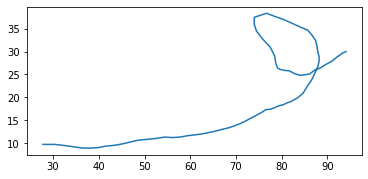

In [16]:
final_gdf = geopandas.GeoDataFrame(group_gdf, geometry = 'geometry')
final_gdf.plot()

In [17]:
# Checking the CRS
print(final_gdf.crs)

None


If you get data that does not include a projection you have to set the CRS so geopandas knows how to interpret the coordinates.

For example, if you convert a spreadsheet of latitudes and longitudes into a GeoSeries by hand, you would set the projection by assigning the WGS84 latitude-longitude CRS to the GeoSeries.crs attribute:

my_geoseries.crs = "epsg:4326"

In [19]:
final_gdf.crs = "epsg:4326"

In [26]:
filename = cyclone_name + '_'+ str(cyclone_year)+ '_centerpath.shp'
outfile = Path.cwd().parent.joinpath('data', filename)
print(outfile)

G:\Omdena\wfpdisrel\#task1-datacollection\#task1-datacollection-climada\data\IVAN_2004_centerpath.shp


In [28]:
#df.to_file(filename='IVAN polygon.geojson', driver='GeoJSON')
final_gdf.to_file(filename=outfile, driver="ESRI Shapefile")

## Choosing the dimension for buffering the path
TODO: choosing the right metrics is crucial for the calculated area

In [29]:
cyclone_gdf['max_34'].value_counts()

0.0      22
150.0    13
140.0    11
75.0      6
250.0     5
60.0      4
225.0     4
175.0     4
120.0     4
100.0     4
50.0      3
110.0     2
125.0     2
190.0     1
180.0     1
90.0      1
Name: max_34, dtype: int64

In [30]:
buffer_radius = 150  # arbitrary value to continue coding , important to check dimensions (currently km are assumed) 

In [31]:
# Project to crs that uses meters as distance measure
cyclone_3395 = final_gdf.to_crs('epsg:3395')
cyclone_3395['geometry']= cyclone_3395.buffer(buffer_radius*1000)
buffered_cyclone_gdf = cyclone_3395.to_crs('epsg:4326')
buffered_cyclone_gdf.head()

,,,geometry
id,name,year,
AL0904,IVAN,2004,"POLYGON ((30.30000 11.03409, 30.44992 11.02582..."


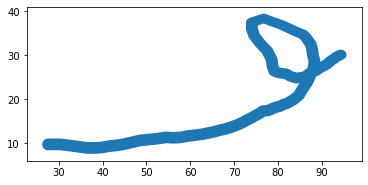

In [32]:
buffered_cyclone_gdf.plot()